# Vancouver Housing distribution map

This notebook will show the distribution of houses for sale in each neighborhood in Vancouver.

In [75]:
import os
import json
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pylab as plt
import geopandas as gpd
%pip install folium
import folium
from shapely.geometry import Point
from shapely import wkt

# Configure Notebook
#for plots to be inline
%matplotlib inline 
#for auto_complete 
%config Completer.use_jedi = False 


Note: you may need to restart the kernel to use updated packages.


In [77]:
# Import data
neighbourhoods = gpd.read_file('local-area-boundary_van.geojson') 

van_1500 = pd.read_csv('Vancouver_Houses_Facilities_1.5km.csv')
van_1000 = pd.read_csv('Vancouver_Houses_Facilities_1km.csv')
van_500 = pd.read_csv('Vancouver_Houses_Facilities_0.5km.csv')

house_data = pd.read_csv('housing_van_clean_with_best_buffers_v2.csv')


neighbourhoods.head()

,name,geo_point_2d,geometry
0,Downtown,"{ ""lon"": -123.11656700827415, ""lat"": 49.280747...","POLYGON ((-123.11 49.29, -123.1 49.288, -123.1..."
1,Hastings-Sunrise,"{ ""lon"": -123.04026992328848, ""lat"": 49.277934...","POLYGON ((-123.06 49.293, -123.05 49.294, -123..."
2,Kerrisdale,"{ ""lon"": -123.15957618168902, ""lat"": 49.223655...","POLYGON ((-123.18 49.216, -123.18 49.215, -123..."
3,Marpole,"{ ""lon"": -123.1283816596551, ""lat"": 49.2102074...","POLYGON ((-123.11 49.204, -123.11 49.204, -123..."
4,Oakridge,"{ ""lon"": -123.12302460370566, ""lat"": 49.226403...","POLYGON ((-123.11 49.233, -123.11 49.219, -123..."


In [79]:
# Drop all columns except for 'geometry', and 'FIELD_8'
neighbourhoods = neighbourhoods[['geometry', 'name']] 
# Rename
neighbourhoods = neighbourhoods.rename(columns={'name': 'neighbourhood'})
# Split the name column at '(' and only keep the name
neighbourhoods['neighbourhood'] = neighbourhoods['neighbourhood'].str.split('(').str[0] 
# Remove any leading or trailing spaces and lower case the neighbourhood
neighbourhoods['neighbourhood'] = neighbourhoods['neighbourhood'].str.strip() 
neighbourhoods['neighbourhood'] = neighbourhoods['neighbourhood'].str.lower()


# View GeoDataFrame
neighbourhoods.head()

,geometry,neighbourhood
0,"POLYGON ((-123.11 49.29, -123.1 49.288, -123.1...",downtown
1,"POLYGON ((-123.06 49.293, -123.05 49.294, -123...",hastings-sunrise
2,"POLYGON ((-123.18 49.216, -123.18 49.215, -123...",kerrisdale
3,"POLYGON ((-123.11 49.204, -123.11 49.204, -123...",marpole
4,"POLYGON ((-123.11 49.233, -123.11 49.219, -123...",oakridge


In [81]:


# Transform neighbourhoods to EPSG:26917
neighbourhoods = neighbourhoods.to_crs(epsg=26917)

# Calculate the area in square kilometers
neighbourhoods['area'] = neighbourhoods.geometry.area / 1e6  # Convert from square meters to square kilometers

# View GeoDataFrame
neighbourhoods.head()

,geometry,neighbourhood,area
0,"POLYGON ((-2.5e+06 6.37e+06, -2.5e+06 6.37e+06...",downtown,5.782060
1,"POLYGON ((-2.49e+06 6.37e+06, -2.49e+06 6.37e+...",hastings-sunrise,10.300109
2,"POLYGON ((-2.51e+06 6.37e+06, -2.51e+06 6.37e+...",kerrisdale,8.182961
3,"POLYGON ((-2.5e+06 6.36e+06, -2.5e+06 6.36e+06...",marpole,7.431784
4,"POLYGON ((-2.5e+06 6.36e+06, -2.5e+06 6.36e+06...",oakridge,4.980075


In [83]:
# Convert to 4326
house_gdf = gpd.GeoDataFrame(
    house_data,
    geometry=gpd.points_from_xy(house_data['longitude'], house_data['latitude']),
    crs="EPSG:4326"
)

# Match the neighbourhoods' CRS (epsg:26917)
house_gdf = house_gdf.to_crs(epsg=26917)


house_data.head()


,street address,neighbourhood,latitude,longitude,price,bedrooms,bathrooms,geometry,total_crimes (2020-2024),average_total_crime (per_year),...,bus stop_best_buffer_area_1.5_values,pub_best_buffer_area_1.5_values,restaurant_best_buffer_area_1.5_values,cafe_best_buffer_area_1.5_values,dentist_best_buffer_area_0.5_values,fast food_best_buffer_area_1.5_values,kindergartens_best_buffer_area_0.5_values,malls_best_buffer_area_0.5_values,play ground_best_buffer_area_0.5_values,post office_best_buffer_area_1.5_values
0,1525 coal harbour cay #b17,downtown,49.291479,-123.128047,375000,1,1.0,point (-123.128047 49.291479),49367,9873,...,93,15,248,104,0,71,0,0,0,10
1,838 hamilton st #1009,downtown,49.278326,-123.116209,350000,2,1.0,point (-123.116209 49.278326),49367,9873,...,164,39,307,183,0,148,0,0,0,11
2,1480 howe st #p5-502,downtown,49.274891,-123.131173,89800,0,1.0,point (-123.131173 49.274891),49367,9873,...,103,18,234,101,0,79,0,0,0,8
3,1159 main st #505,downtown,49.274261,-123.100494,768000,2,2.0,point (-123.100494 49.274261),49367,9873,...,137,29,146,73,0,54,0,0,0,4
4,138 hastings st e #206,downtown,49.281058,-123.101197,359000,1,1.0,point (-123.101197 49.281058),49367,9873,...,128,31,124,77,0,70,0,0,0,3


In [85]:
# add new column that represents stations in each neighbourhoods
neighbourhoods['house_counts'] = neighbourhoods.apply(lambda row: house_gdf.within(row.geometry).sum(),axis = 1)
# sort value with descending order
neighbourhoods = neighbourhoods.sort_values('house_counts', ascending = False)
neighbourhoods['house_density'] = neighbourhoods['house_counts'] / neighbourhoods['area']
# View GeoDataFrame
neighbourhoods[['neighbourhood', 'geometry','area','house_counts', 'house_density']].head(10)

,neighbourhood,geometry,area,house_counts,house_density
0,downtown,"POLYGON ((-2.5e+06 6.37e+06, -2.5e+06 6.37e+06...",5.782060,237,40.988853
18,kitsilano,"POLYGON ((-2.5e+06 6.37e+06, -2.5e+06 6.37e+06...",7.875231,82,10.412394
10,fairview,"POLYGON ((-2.5e+06 6.37e+06, -2.5e+06 6.37e+06...",4.498265,80,17.784637
16,kensington-cedar cottage,"POLYGON ((-2.49e+06 6.36e+06, -2.5e+06 6.36e+0...",8.970721,76,8.472006
11,mount pleasant,"POLYGON ((-2.5e+06 6.37e+06, -2.5e+06 6.37e+06...",4.602341,75,16.296056
13,west end,"POLYGON ((-2.5e+06 6.37e+06, -2.5e+06 6.37e+06...",2.791365,72,25.793830
12,renfrew-collingwood,"POLYGON ((-2.49e+06 6.36e+06, -2.49e+06 6.36e+...",10.016662,61,6.089853
1,hastings-sunrise,"POLYGON ((-2.49e+06 6.37e+06, -2.49e+06 6.37e+...",10.300109,54,5.242663
7,shaughnessy,"POLYGON ((-2.5e+06 6.37e+06, -2.5e+06 6.37e+06...",5.545281,45,8.115008
5,riley park,"POLYGON ((-2.5e+06 6.36e+06, -2.5e+06 6.36e+06...",6.102006,44,7.210743


In [87]:
# Use spatial join to match each property with its neighbourhood
house_merged = gpd.sjoin(house_gdf, neighbourhoods[['neighbourhood', 'geometry', 'area', 'house_counts', 'house_density']], how='left', predicate='within')

house_merged.head()

,street address,neighbourhood_left,latitude,longitude,price,bedrooms,bathrooms,geometry,total_crimes (2020-2024),average_total_crime (per_year),...,fast food_best_buffer_area_1.5_values,kindergartens_best_buffer_area_0.5_values,malls_best_buffer_area_0.5_values,play ground_best_buffer_area_0.5_values,post office_best_buffer_area_1.5_values,index_right,neighbourhood_right,area,house_counts,house_density
0,1525 coal harbour cay #b17,downtown,49.291479,-123.128047,375000,1,1.0,POINT (-2.5e+06 6.37e+06),49367,9873,...,71,0,0,0,10,0,downtown,5.78206,237,40.988853
1,838 hamilton st #1009,downtown,49.278326,-123.116209,350000,2,1.0,POINT (-2.5e+06 6.37e+06),49367,9873,...,148,0,0,0,11,0,downtown,5.78206,237,40.988853
2,1480 howe st #p5-502,downtown,49.274891,-123.131173,89800,0,1.0,POINT (-2.5e+06 6.37e+06),49367,9873,...,79,0,0,0,8,0,downtown,5.78206,237,40.988853
3,1159 main st #505,downtown,49.274261,-123.100494,768000,2,2.0,POINT (-2.5e+06 6.37e+06),49367,9873,...,54,0,0,0,4,0,downtown,5.78206,237,40.988853
4,138 hastings st e #206,downtown,49.281058,-123.101197,359000,1,1.0,POINT (-2.5e+06 6.37e+06),49367,9873,...,70,0,0,0,3,0,downtown,5.78206,237,40.988853


# Map Plot 

This section will display a map of Vancouver showing the locations of houses for sale and the density of house sales in each neighborhood.

In [57]:
from folium import Choropleth

In [59]:

# Remove rows where house_density is 0
neighbourhoods = neighbourhoods[neighbourhoods['house_density'] != 0]

In [61]:
plot_geography = neighbourhoods.to_crs(epsg=4326)[['neighbourhood', 'geometry']]
plot_geography = plot_geography.set_index('neighbourhood')
plot_geography.head()

,geometry
neighbourhood,
downtown,"POLYGON ((-123.11 49.29, -123.1 49.288, -123.1..."
kitsilano,"POLYGON ((-123.14 49.275, -123.14 49.273, -123..."
fairview,"POLYGON ((-123.15 49.257, -123.15 49.272, -123..."
kensington-cedar cottage,"POLYGON ((-123.06 49.262, -123.06 49.243, -123..."
mount pleasant,"POLYGON ((-123.1 49.269, -123.1 49.267, -123.1..."


In [63]:
plot_data = neighbourhoods[['neighbourhood', 'house_density']]
plot_data.head()

,neighbourhood,house_density
0,downtown,40.988853
18,kitsilano,10.412394
10,fairview,17.784637
16,kensington-cedar cottage,8.472006
11,mount pleasant,16.296056


In [65]:
# Create a map centered on Vancouver
map_vancouver = folium.Map(location=[49.2827, -123.1207], 
                           tiles='cartodbpositron',
                           zoom_start=10)

# Add a choropleth map to the base map
Choropleth(geo_data=plot_geography.__geo_interface__, 
           columns=['neighbourhood', 'house_density'],
           data=plot_data, 
           key_on='feature.id', 
           fill_color='YlOrRd', 
           legend_name='House Density (house / km²)'
          ).add_to(map_vancouver)

map_vancouver

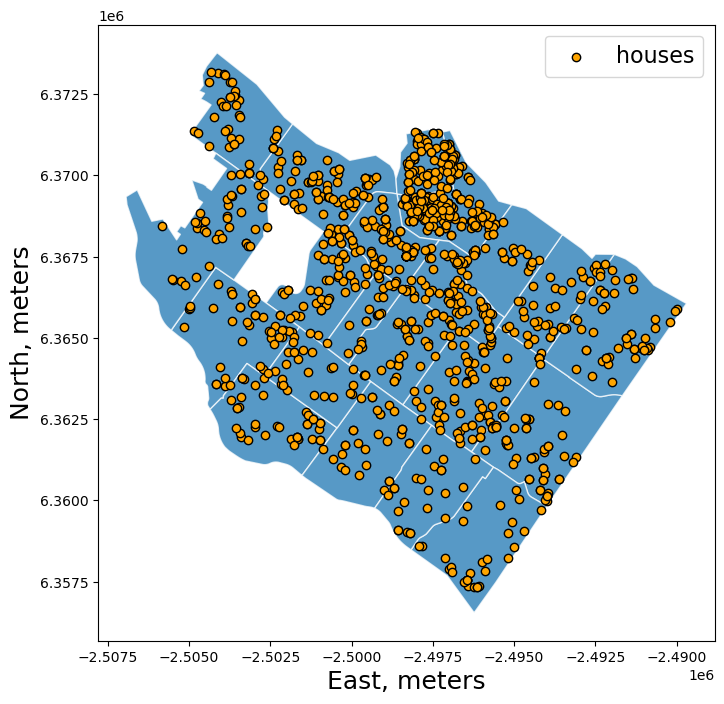

In [67]:
ax = neighbourhoods.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)
house_gdf.plot(ax=ax, color='orange', edgecolor='k', label='houses')
plt.legend(fontsize=16)
plt.xlabel('East, meters', fontsize=18)
plt.ylabel('North, meters', fontsize=18);

In [69]:
from folium.plugins import HeatMap

In [71]:
# Create a map of Toronto
map_2 = folium.Map(location=[49.2827, -123.1207], 
                           tiles='cartodbpositron',
                           zoom_start=10)

# Add points to the map
HeatMap(data=list(zip(house_gdf.to_crs(epsg=4326).geometry.y,
                      house_gdf.to_crs(epsg=4326).geometry.x)),
        radius=20).add_to(map_2)

# Display map
map_2

## Calculate the total facilities around each house 

In [55]:
van_1500['Total Facilities 1500'] = van_1500[
    [
        'Hospital in area', 
        'Railway Station in area', 
        'School in area', 
        'Supermarket in area', 
        'Bus Stop in area', 
        'Pub in area', 
        'Restaurant in area',  
        'Cafe in area', 
        'Dentist in area', 
        'Fast Food in area', 
        'Kindergartens in area', 
        'Malls in area',  
        'Play Ground in area',  
        'Parks in area',  
        'Post Office in area'
    ]
].sum(axis=1)

van_1000['Total Facilities 1000'] = van_1000[
    [
        'Hospital in area', 
        'Railway Station in area', 
        'School in area', 
        'Supermarket in area', 
        'Bus Stop in area', 
        'Pub in area', 
        'Restaurant in area',  
        'Cafe in area', 
        'Dentist in area', 
        'Fast Food in area', 
        'Kindergartens in area', 
        'Malls in area',  
        'Play Ground in area',  
        'Parks in area',  
        'Post Office in area'
    ]
].sum(axis=1)

van_500['Total Facilities 500'] = van_500[
    [
        'Hospital in area', 
        'Railway Station in area', 
        'School in area', 
        'Supermarket in area', 
        'Bus Stop in area', 
        'Pub in area', 
        'Restaurant in area',  
        'Cafe in area', 
        'Dentist in area', 
        'Fast Food in area', 
        'Kindergartens in area', 
        'Malls in area',  
        'Play Ground in area',  
        'Parks in area',  
        'Post Office in area'
    ]
].sum(axis=1)

van_500['street address'] = van_500['Street address'].str.lower()
van_1000['street address'] = van_1000['Street address'].str.lower()
van_1500['street address'] = van_1500['Street address'].str.lower()


house_merged = house_merged.merge(van_500[['street address', 'Total Facilities 500']], 
                                  on='street address', 
                                  how='left', 
                                  suffixes=('', '_500m'))


house_merged = house_merged.merge(van_1000[['street address', 'Total Facilities 1000']], 
                                  on='street address', 
                                  how='left', 
                                  suffixes=('', '_1000m'))


house_merged = house_merged.merge(van_1500[['street address', 'Total Facilities 1500']], 
                                  on='street address', 
                                  how='left', 
                                  suffixes=('', '_1500m'))

# Renaming the columns for clarity
house_merged.rename(columns={
    'Total Facilities_500m': 'Total Facilities within 500m',
    'Total Facilities_1000m': 'Total Facilities within 1000m',
    'Total Facilities_1500m': 'Total Facilities within 1500m'
}, inplace=True)


house_merged.to_csv('final_merged_van.csv')
